<h1 style="text-align: center;">Floquet with QuTiP <h1>


The Hamiltonian of interest is given by 
$$
H_{\text{full}}(t) = \omega_0 a^\dagger a + \sum_{n=3}^\infty g_n (a^\dagger + a)^n - i\Omega_d \cos(\omega_d t) (a -a^\dagger),
$$
where depending on which paper I read or who I ask one can see $g_n$ defined as $g_n/n$, a factor of $2$ in front of the $\Omega_d$ term, and even an extra driving $\propto \Omega_1 \cos(\omega_1 t) (a -a^\dagger)$. These differences are mostly trivial but know they exist. We now proceed to investigate the spectrum of $H_{\text{full}}(t)$ under several regimes: an static effecitve regime (Sec. 1 bellow) and a Floquet regime (Sec. 2).

Anyways, in QuTiP we define it like
$$
H(t) = H_0 + H_d\cos(\omega_d t),
$$
where $H_0$ and $H_d$ are obvious from context.

In [1]:
from qutip import *
import numpy as np
from numpy import linalg as LA
from tqdm import tqdm_notebook

# where g_n is a Numpy vector whose length defines the order of the well
def H_0(N,w_0, g_n):
    well_ord = len(g_n)
    kinetic = w_0*create(N)*destroy(N) 
    well_vect = np.array( [(create(N) + destroy(N))**n for n in range(3,well_ord+3) ])
    well = np.einsum('i,ijk', g_n, well_vect)
    return kinetic + well
    
def H_d(N,Omega_d):
    return -1j*Omega_d*(destroy(N)-create(N))

def H_full(N,w_0, g_n, Omega_d):
    return [H_0(N,w_0, g_n), [H_d(N,Omega_d), 'cos(w_d * t)']]

def H(N,w_0, g_n,Omega_d,w_d,t):
    return  H_0(N,w_0, g_n) + np.cos(w_d*t) * H_d(N,Omega_d)



and now for the actual computation

In [5]:
N = 30
w_0 = 1
g_n = np.array([1/4,1])
w_d = 1

Omega_d_array = np.linspace(1,10,20)

Delta_E = np.zeros((len(Omega_d_array),N))
Omega_d_matrix = np.zeros((len(Omega_d_array),N))
for i, Omega_d in enumerate(Omega_d_array):
    print(i/len(Omega_d))
    args = {'w_d': w_d}
    H = H_full(N,w_0, g_n, Omega_d)
    T = 2*np.pi / w_d
    _, f_energies = floquet_modes(H, T, args, options=Options(nsteps=1000000))
    Delta_E[i,:] = f_energies - min(f_energies)
    Omega_d_matrix[i,:] = Omega_d

/var/folders/v1/xrps7b392_3f75y4rhby8nl00000gn/T/ipykernel_68229/1661392925.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, Omega_d in tqdm_notebook(enumerate(Omega_d_array)):


0it [00:00, ?it/s]

/var/folders/v1/xrps7b392_3f75y4rhby8nl00000gn/T/ipykernel_68229/1661392925.py:15: RuntimeWarning: invalid value encountered in log
  Delta_E[i,:] = np.log(f_energies)/T - min(np.log(f_energies))/T


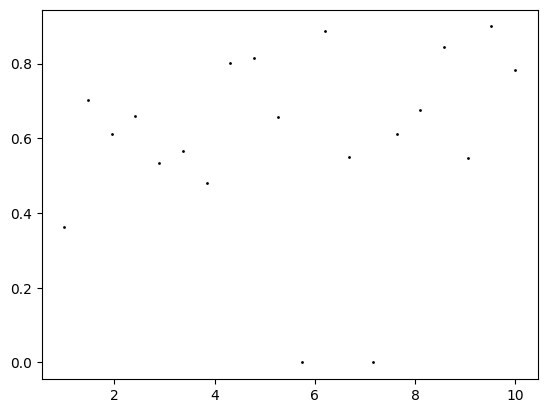

In [63]:
import matplotlib.pyplot as plt
for i in range(len(Omega_d_array)):
    plt.scatter(Omega_d_array[i],Delta_E[i,1],color="k",s=1)
plt.show()


In [19]:
def H_t(t,args):
    N = 10
    w_0 = 1
    g_n = np.array([1,1/2])
    Omega_d = 1
    w_d = 1
    return H(N,w_0, g_n,Omega_d,w_d,t)
w_d = 1
T = 2*np.pi / w_d
t_array = np.linspace(0,2*T,50) # 2 periods cause Rodrigo said so

U_t = propagator(H_t, t_array, options=None, unitary_mode='batch', parallel=False, progress_bar=None)
U_2T = U_t[-1]

Note is not hermitian!!!

In [18]:
quasienergies = LA.eigvalsh(U_T[-1])
U_T[-1].check_herm()

False

In [8]:
t_array = np.linspace(0,T,50)
U_2T = propagator(H_t, t_array, options=None, unitary_mode='batch', parallel=False, progress_bar=None)
U_2T[len(U_2T)//2]

Quantum object: dims = [[10], [10]], shape = (10, 10), type = oper, isherm = False
Qobj data =
[[-0.53271941-0.36934857j -0.10749188-0.00432249j  0.22793042+0.04275736j
   0.112795  +0.28752374j -0.30484122-0.00087402j  0.01886404-0.30688462j
   0.28969093-0.01762231j -0.09924493+0.2424861j  -0.16515897+0.00902086j
   0.12453685-0.1899292j ]
 [-0.11890615+0.0297784j   0.65522174+0.09937619j -0.47286266+0.21576275j
  -0.18446964-0.05566322j  0.13014302+0.15599089j  0.13237537-0.15437313j
   0.15590232-0.20914413j -0.13601144+0.11592388j -0.15397693+0.11658857j
   0.12194938-0.06226612j]
 [ 0.23129904+0.01775087j -0.48636973+0.20013727j -0.42084618+0.3504194j
   0.35953534+0.13488093j  0.13786945-0.1966717j  -0.00966137-0.08085172j
   0.15229111-0.23387424j -0.01367024+0.05988156j -0.17638065+0.19434872j
  -0.06640672-0.05556376j]
 [ 0.12500885+0.28203563j -0.18123458-0.02700031j  0.37313068+0.134669j
  -0.18887264-0.11717149j -0.0470645 +0.28398274j  0.38354316-0.29061781j
   0.21262147

In [ ]:
U_2T[len(U_2T)//2]

array([-0.13174077,  0.03011839, -0.24395926,  0.33269845,  0.34914791,
       -0.33740245, -0.43129531,  0.47624471,  0.43477849, -0.47886893])

In [21]:
def f(x):
    return x**2

[f(t) for t in t_array]

[0.0,
 0.016442489631135954,
 0.06576995852454381,
 0.14798240668022358,
 0.26307983409817526,
 0.4110622407783988,
 0.5919296267208943,
 0.8056819919256618,
 1.052319336392701,
 1.3318416601220122,
 1.6442489631135953,
 1.9895412453674506,
 2.3677185068835773,
 2.778780747661976,
 3.2227279677026472,
 3.6995601670055898,
 4.209277345570804,
 4.751879503398291,
 5.327366640488049,
 5.935738756840078,
 6.576995852454381,
 7.251137927330957,
 7.958164981469802,
 8.69807701487092,
 9.47087402753431,
 10.27655601945997,
 11.115122990647905,
 11.986574941098109,
 12.890911870810589,
 13.82813377978534,
 14.798240668022359,
 15.801232535521653,
 16.837109382283217,
 17.905871208307058,
 19.007518013593163,
 20.142049798141546,
 21.309466561952195,
 22.509768305025123,
 23.742955027360313,
 25.00902672895779,
 26.307983409817524,
 27.63982506993954,
 29.004551709323827,
 30.402163327970378,
 31.83265992587921,
 33.296041503050304,
 34.79230805948368,
 36.32145959517932,
 37.88349611013724,
 3

In [18]:
t_array = np.linspace(0,T,50)


In [19]:
t_array

array([0.        , 0.12822827, 0.25645654, 0.38468481, 0.51291309,
       0.64114136, 0.76936963, 0.8975979 , 1.02582617, 1.15405444,
       1.28228272, 1.41051099, 1.53873926, 1.66696753, 1.7951958 ,
       1.92342407, 2.05165235, 2.17988062, 2.30810889, 2.43633716,
       2.56456543, 2.6927937 , 2.82102197, 2.94925025, 3.07747852,
       3.20570679, 3.33393506, 3.46216333, 3.5903916 , 3.71861988,
       3.84684815, 3.97507642, 4.10330469, 4.23153296, 4.35976123,
       4.48798951, 4.61621778, 4.74444605, 4.87267432, 5.00090259,
       5.12913086, 5.25735913, 5.38558741, 5.51381568, 5.64204395,
       5.77027222, 5.89850049, 6.02672876, 6.15495704, 6.28318531])